# Timeseries

Ce notebook présente quelques étapes simples pour une série temporelle. La plupart utilise le module [statsmodels.tsa](https://www.statsmodels.org/stable/tsa.html#module-statsmodels.tsa).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Données

Les données sont artificielles mais simulent ce que pourraient être le chiffre d'affaires d'un magasin de quartier, des samedi très forts, une semaine morne, un Noël chargé, un été plat.

In [3]:
from ensae_teaching_cs.data import generate_sells
import pandas
df = pandas.DataFrame(generate_sells())
df.head()

,date,value
0,2020-02-13 18:54:23.461489,0.005357
1,2020-02-14 18:54:23.461489,0.009562
2,2020-02-15 18:54:23.461489,0.014353
3,2020-02-16 18:54:23.461489,0.000000
4,2020-02-17 18:54:23.461489,0.003475


## Premiers graphiques

La série a deux saisonnalités, hebdomadaire, mensuelle.

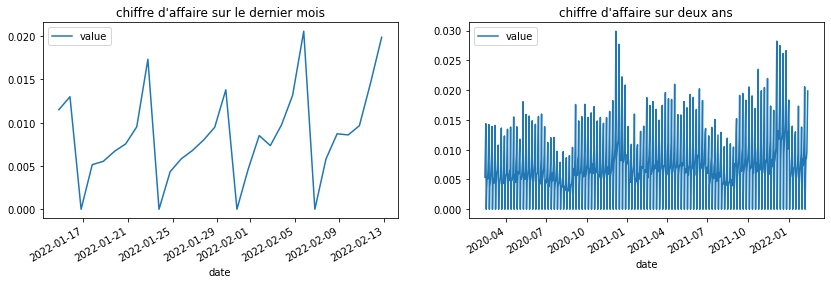

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df.iloc[-30:].set_index('date').plot(ax=ax[0])
df.set_index('date').plot(ax=ax[1])
ax[0].set_title("chiffre d'affaire sur le dernier mois")
ax[1].set_title("chiffre d'affaire sur deux ans");

Elle a une vague tendance, on peut calculer un tendance à l'ordre 1, 2, ...

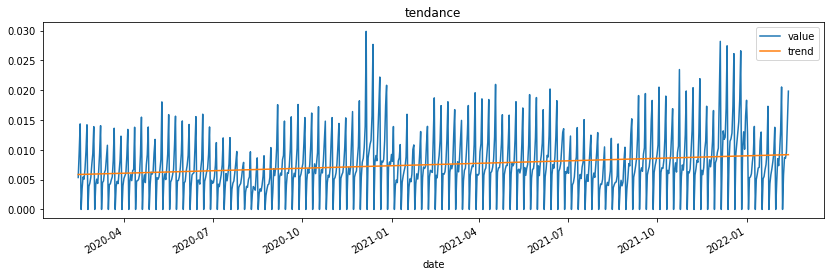

In [5]:
from statsmodels.tsa.tsatools import detrend
notrend = detrend(df.value, order=1)
df["notrend"] = notrend
df["trend"] = df['value'] - notrend
ax = df.plot(x="date", y=["value", "trend"], figsize=(14,4))
ax.set_title('tendance');

Autocorrélations...

In [6]:
from statsmodels.tsa.stattools import acf
cor = acf(df.value)
cor

C:\Python395_x64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Python395_x64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Python395_x64\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Python395_x64\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the relea

array([ 1.        ,  0.03577944, -0.06235687, -0.02029818, -0.02898255,
       -0.06825401,  0.0250769 ,  0.93062748,  0.0120951 , -0.08157127,
       -0.04537123, -0.05365516, -0.08887674,  0.00289459,  0.88395645,
       -0.01531838, -0.1028712 , -0.06616495, -0.07120575, -0.10659382,
       -0.01690792,  0.84848022, -0.0335295 , -0.12382299, -0.08744705,
       -0.09339856, -0.12657065, -0.04305763,  0.80550906, -0.05483815,
       -0.14409999, -0.10895806, -0.10812254, -0.14125818, -0.05846692,
        0.79099037, -0.05773434, -0.14731918, -0.10789494, -0.10483253,
       -0.14058412])

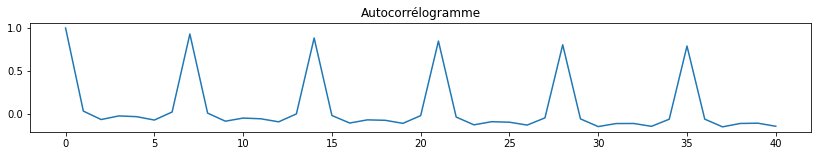

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(14,2))
ax.plot(cor)
ax.set_title("Autocorrélogramme");

La première saisonalité apparaît, 7, 14, 21... Les autocorrélations partielles confirment cela, plutôt 7 jours.

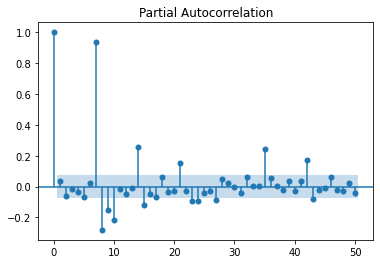

In [8]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df.value, lags=50);

Comme il n'y a rien le dimanche, il vaut mieux les enlever. Garder des zéros nous priverait de modèles multiplicatifs.

In [9]:
df["weekday"] = df.date.dt.weekday
df.head()

,date,value,notrend,trend,weekday
0,2020-02-13 18:54:23.461489,0.005357,-0.000507,0.005864,3
1,2020-02-14 18:54:23.461489,0.009562,0.003694,0.005868,4
2,2020-02-15 18:54:23.461489,0.014353,0.008481,0.005873,5
3,2020-02-16 18:54:23.461489,0.000000,-0.005877,0.005877,6
4,2020-02-17 18:54:23.461489,0.003475,-0.002407,0.005882,0


In [10]:
df_nosunday = df[df.weekday != 6]
df_nosunday.head(n=10)

,date,value,notrend,trend,weekday
0,2020-02-13 18:54:23.461489,0.005357,-0.000507,0.005864,3
1,2020-02-14 18:54:23.461489,0.009562,0.003694,0.005868,4
2,2020-02-15 18:54:23.461489,0.014353,0.008481,0.005873,5
4,2020-02-17 18:54:23.461489,0.003475,-0.002407,0.005882,0
5,2020-02-18 18:54:23.461489,0.005454,-0.000432,0.005886,1
6,2020-02-19 18:54:23.461489,0.005075,-0.000816,0.005891,2
7,2020-02-20 18:54:23.461489,0.006801,0.000906,0.005896,3
8,2020-02-21 18:54:23.461489,0.009831,0.003931,0.005900,4
9,2020-02-22 18:54:23.461489,0.014204,0.008299,0.005905,5
11,2020-02-24 18:54:23.461489,0.003875,-0.002039,0.005914,0


C:\Python395_x64\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Python395_x64\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


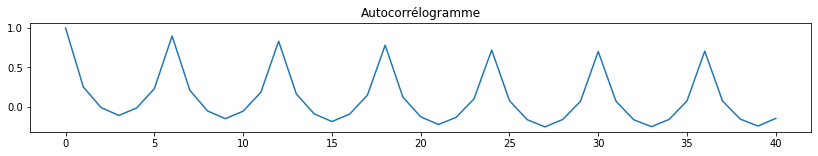

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(14,2))
cor = acf(df_nosunday.value)
ax.plot(cor)
ax.set_title("Autocorrélogramme");

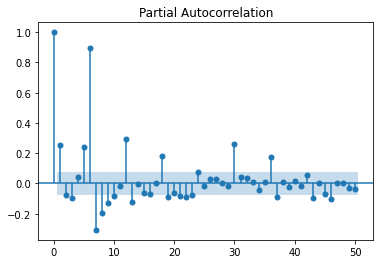

In [12]:
plot_pacf(df_nosunday.value, lags=50);

On décompose la série en tendance + saisonnalité. Les étés et Noël apparaissent.

<ipython-input-13-a9c8eeeaae9a>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead.
  res = seasonal_decompose(df_nosunday.value, freq=7)


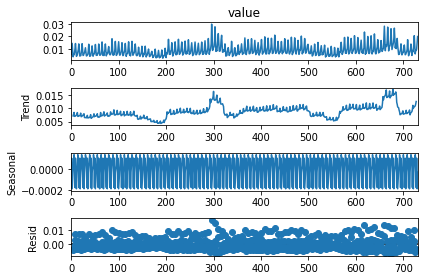

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(df_nosunday.value, freq=7)
res.plot();

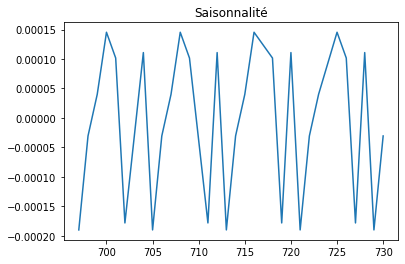

In [14]:
plt.plot(res.seasonal[-30:])
plt.title("Saisonnalité");

C:\Python395_x64\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Python395_x64\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


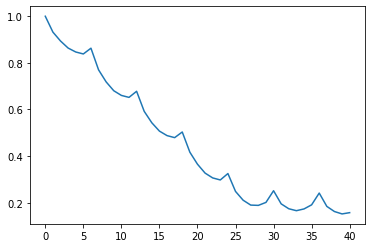

In [15]:
cor = acf(res.trend[5:-5]);
plt.plot(cor);

On cherche maintenant la saisonnalité de la série débarrassée de sa tendance herbdomadaire. On retrouve la saisonnalité mensuelle.

<ipython-input-16-285cbf1eb085>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead.
  res_year = seasonal_decompose(res.trend[5:-5], freq=25)


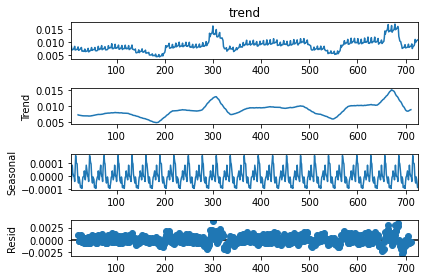

In [16]:
res_year = seasonal_decompose(res.trend[5:-5], freq=25)
res_year.plot();

## Test de stationnarité

Le test [KPSS](https://en.wikipedia.org/wiki/KPSS_test) permet de tester la stationnarité d'une série.

In [17]:
from statsmodels.tsa.stattools import kpss
kpss(res.trend[5:-5])

C:\Python395_x64\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Python395_x64\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(0.980161988153884,
 0.01,
 19,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Comme ce n'est pas toujours facile à interpréter, on simule une variable aléatoire gaussienne donc sans tendance.

In [18]:
from numpy.random import randn
bruit = randn(1000)
kpss(bruit)

(0.4813396167770415,
 0.04586945568084651,
 22,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Et puis une série avec une tendance forte.

In [19]:
from numpy.random import randn
from numpy import arange
bruit = randn(1000) * 100 + arange(1000) / 10
kpss(bruit)

C:\Python395_x64\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(2.9761535894770517,
 0.01,
 22,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Une valeur forte indique une tendance et la série en a clairement une.

## Prédiction

Les modèles *AR*, *ARMA*, *ARIMA* se concentrent sur une série à une dimension. En machine learning, il y a la série et plein d'autres informations. On construit une matrice avec des séries décalées.

In [20]:
from statsmodels.tsa.tsatools import lagmat
lag = 8
X = lagmat(df_nosunday["value"], lag)
lagged = df_nosunday.copy()
for c in range(1,lag+1):
    lagged["lag%d" % c] = X[:, c-1]
lagged.tail()

,date,value,notrend,trend,weekday,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8
726,2022-02-08 18:54:23.461489,0.008707,-0.000466,0.009173,1,0.005806,0.020552,0.013143,0.009727,0.007346,0.008504,0.004580,0.013786
727,2022-02-09 18:54:23.461489,0.008582,-0.000596,0.009178,2,0.008707,0.005806,0.020552,0.013143,0.009727,0.007346,0.008504,0.004580
728,2022-02-10 18:54:23.461489,0.009646,0.000464,0.009182,3,0.008582,0.008707,0.005806,0.020552,0.013143,0.009727,0.007346,0.008504
729,2022-02-11 18:54:23.461489,0.014557,0.005370,0.009187,4,0.009646,0.008582,0.008707,0.005806,0.020552,0.013143,0.009727,0.007346
730,2022-02-12 18:54:23.461489,0.019851,0.010660,0.009191,5,0.014557,0.009646,0.008582,0.008707,0.005806,0.020552,0.013143,0.009727


On ajoute ou on réécrit le jour de la semaine qu'on utilise comme variable supplémentaire.

In [21]:
lagged["weekday"] = lagged.date.dt.weekday

In [22]:
X = lagged.drop(["date", "value", "notrend", "trend"], axis=1)
Y = lagged["value"]
X.shape, Y.shape

((627, 9), (627,))

In [23]:
from numpy import corrcoef
corrcoef(X)

array([[1.        , 0.99999912, 0.99999792, ..., 0.99999049, 0.99999476,
        0.99999663],
       [0.99999912, 1.        , 0.99999936, ..., 0.99998874, 0.99999358,
        0.99999672],
       [0.99999792, 0.99999936, 1.        , ..., 0.99998653, 0.99999169,
        0.99999553],
       ...,
       [0.99999049, 0.99998874, 0.99998653, ..., 1.        , 0.9999852 ,
        0.99998403],
       [0.99999476, 0.99999358, 0.99999169, ..., 0.9999852 , 1.        ,
        0.99999084],
       [0.99999663, 0.99999672, 0.99999553, ..., 0.99998403, 0.99999084,
        1.        ]])

Etrange autant de grandes valeurs, cela veut dire que la tendance est trop forte pour calculer des corrélations, il vaudrait mieux tout recommencer avec la série $\Delta Y_t = Y_t - Y_{t-1}$. Bref, passons...

In [24]:
X.columns

Index(['weekday', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7',
       'lag8'],
      dtype='object')

Une régression linéaire car les modèles linéaires sont toujours de bonnes baseline et pour connaître le modèle simulé, on ne fera pas beaucoup mieux.

In [25]:
from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X, Y)

LinearRegression()

In [26]:
from sklearn.metrics import r2_score
r2_score(Y, clr.predict(X))

0.8789132280236231

In [27]:
clr.coef_

array([ 0.0016414 ,  0.34593324,  0.26436686,  0.08632379,  0.01356802,
       -0.03755237,  0.40831821, -0.12106444, -0.07772163])

On retrouve la saisonnalité, $Y_t$ et $Y_{t-6}$ sont de mèches.

In [28]:
for i in range(1, X.shape[1]):
    print("X(t-%d)" % (i), r2_score(Y, X.iloc[:, i]))

X(t-1) -0.48934404097448847
X(t-2) -1.0143639444424148
X(t-3) -1.228186547024929
X(t-4) -1.0378510803717922
X(t-5) -0.5496246593771723
X(t-6) 0.7876799792178883
X(t-7) -0.5843479675288277
X(t-8) -1.1145521360143462


Auparavant (l'année dernière en fait), je construisais deux bases, apprentissage et tests, comme ceci :

In [29]:
n = X.shape[0]
X_train = X.iloc[:n * 2//3]
X_test = X.iloc[n * 2//3:]
Y_train = Y[:n * 2//3]
Y_test = Y[n * 2//3:]

Et puis *scikit-learn* est arrivée avec [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [30]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(lagged):
    data_train, data_test = lagged.iloc[train_index, :], lagged.iloc[test_index, :]
    print("TRAIN:", data_train.shape, "TEST:", data_test.shape)

TRAIN: (107, 13) TEST: (104, 13)
TRAIN: (211, 13) TEST: (104, 13)
TRAIN: (315, 13) TEST: (104, 13)
TRAIN: (419, 13) TEST: (104, 13)
TRAIN: (523, 13) TEST: (104, 13)


Et on calé une forêt aléatoire...

In [31]:
import warnings
from sklearn.ensemble import RandomForestRegressor
clr = RandomForestRegressor()

def train_test(clr, train_index, test_index):
    data_train = lagged.iloc[train_index, :]
    data_test = lagged.iloc[test_index, :]
    clr.fit(data_train.drop(["value", "date", "notrend", "trend"], 
                            axis=1), 
            data_train.value)
    r2 = r2_score(data_test.value,
                  clr.predict(data_test.drop(["value", "date", "notrend",
                                              "trend"], axis=1).values))
    return r2

warnings.simplefilter("ignore")
last_test_index = None
for train_index, test_index in tscv.split(lagged):
    r2 = train_test(clr, train_index, test_index)        
    if last_test_index is not None:
        r2_prime = train_test(clr, last_test_index, test_index)        
        print(r2, r2_prime)
    else:
        print(r2)
    last_test_index = test_index

0.8074141052461008
0.740621811076557 0.6980805419883442
0.9382338424157237 0.938776218559058
0.8763703927657517 0.7726502689480175
0.6429356690810921 0.6615420727005181


2 ans coupé en 5, soit tous les 5 mois, ça veut dire que ce découpage inclut parfois Noël, parfois l'été et que les performances y seront très sensibles.

In [32]:
from sklearn.metrics import r2_score
r2 = r2_score(data_test.value,
              clr.predict(data_test.drop(["value", "date", "notrend",
                                          "trend"], axis=1).values))
r2

0.6615420727005181

On compare avec le $r_2$ avec le même $r_2$ obtenu en utilisant $Y_{t-1}$, $Y_{t-2}$, ... $Y_{t-d}$ comme prédiction.

In [33]:
for i in range(1, 9):
    print(i, ":", r2_score(data_test.value, data_test["lag%d" % i]))

1 : -0.5322711277436745
2 : -1.0330346880701402
3 : -1.2289501631550408
4 : -1.0866973927813812
5 : -0.6533003518045957
6 : 0.683558097073121
7 : -0.6863597347439538
8 : -1.2181386641893033


In [34]:
lagged[:5]

,date,value,notrend,trend,weekday,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8
0,2020-02-13 18:54:23.461489,0.005357,-0.000507,0.005864,3,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,2020-02-14 18:54:23.461489,0.009562,0.003694,0.005868,4,0.005357,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,2020-02-15 18:54:23.461489,0.014353,0.008481,0.005873,5,0.009562,0.005357,0.000000,0.000000,0.0,0.0,0.0,0.0
4,2020-02-17 18:54:23.461489,0.003475,-0.002407,0.005882,0,0.014353,0.009562,0.005357,0.000000,0.0,0.0,0.0,0.0
5,2020-02-18 18:54:23.461489,0.005454,-0.000432,0.005886,1,0.003475,0.014353,0.009562,0.005357,0.0,0.0,0.0,0.0


En fait le jour de la semaine est une variable catégorielle, on crée une colonne par jour.

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [36]:
cols = ['lag1', 'lag2', 'lag3',
        'lag4', 'lag5', 'lag6', 'lag7', 'lag8']
ct = ColumnTransformer(
        [('pass', "passthrough", cols),
         ("dummies", OneHotEncoder(), ["weekday"])])
pred = ct.fit(lagged).transform(lagged[:5])
pred

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        ],
       [0.0053571 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        ],
       [0.00956219, 0.0053571 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        ],
       [0.01435337, 0.00956219, 0.0053571 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.00347454, 0.01435337, 0.00956219, 0.0053571 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        ]])

On met tout dans un pipeline parce que c'est plus joli, plus pratique aussi.

In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD 
cols = ['lag1', 'lag2', 'lag3',
        'lag4', 'lag5', 'lag6', 'lag7', 'lag8']
model = make_pipeline(
         make_pipeline(
                 ColumnTransformer(
                    [('pass', "passthrough", cols),
                     ("dummies", make_pipeline(OneHotEncoder(), 
                                               TruncatedSVD(n_components=2)), ["weekday"])]),
        LinearRegression()))
model.fit(lagged, lagged["value"])

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pass',
                                                                   'passthrough',
                                                                   ['lag1',
                                                                    'lag2',
                                                                    'lag3',
                                                                    'lag4',
                                                                    'lag5',
                                                                    'lag6',
                                                                    'lag7',
                                                                    'lag8']),
                                                                  ('dummies',
                                                                   Pipe

C'est plus facile à voir visuellement.

In [38]:
from mlinsights.plotting import pipeline2dot
dot = pipeline2dot(model, lagged)
from jyquickhelper import RenderJsDot
RenderJsDot(dot)

In [39]:
r2_score(lagged['value'], model.predict(lagged))

0.8800492232136333

## Templating

Complètement hors sujet mais utile.

In [40]:
from jinja2 import Template
template = Template('Hello {{ name }}!')
template.render(name='John Doe')

'Hello John Doe!'

In [41]:
template = Template("""
{{ name }}
{{ "-" * len(name) }}
Possède :
{% for i in range(len(meubles)) %}
- {{meubles[i]}}{% endfor %}
""")
meubles = ['table', "tabouret"]
print(template.render(name='John Doe Doe', len=len,
                     meubles=meubles))


John Doe Doe
------------
Possède :

- table
- tabouret
